In [1]:
import numpy as np
import os
import yaml
from pprint import pprint
from lomentum.loader import read_element
from lomentum.plotting import plotter
from qcodes.instrument.base import InstrumentBase
from qdev_wrappers.station_configurator import StationConfigurator
from qdev_wrappers.customised_instruments.interfaces.microwave_source_interface import SimulatedMicrowaveSourceInterface, SGS100AMicrowaveSourceInterface
from qdev_wrappers.customised_instruments.interfaces.AWG_interface import SimulatedAWGInterface, AWG5014Interface
from qdev_wrappers.customised_instruments.composite_instruments.parametric_sequencer.parametric_sequencer import ParametricSequencer
from qdev_wrappers.customised_instruments.composite_instruments.sidebander.sidebander import Sidebander

/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/logger.py:16: UserWarning: The logger.py of qdev-wrappers is deprecated and will be removed soon. Please use the logger of QCoDeS instead.
  warnings.warn('The logger.py of qdev-wrappers is deprecated and will be '
/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/station_configurator.py:21: UserWarning: ruamel yaml not found station configurator is falling back to pyyaml. It's highly recommended to install ruamel.yaml. This fixes issues with scientific notation and duplicate instruments in the YAML file
  warnings.warn("ruamel yaml not found station configurator is falling back to pyyaml. "


In [2]:
def print_params(instr):
    print('\n')
    print(instr.name.upper())
    for k, v in instr.parameters.items():
        if k != 'IDN':
            print(k, ': ', v())
    for k, v in instr.submodules.items():
        if isinstance(v, InstrumentBase):
            print_params(v)

## Sidebander Simple Example
The sidebander is an instrument which given a parametric sequencer and a carrier uses the sequencer to modulate the carrier to produce a single sideband. The instrument keeps track of the sideband information and the sequencer information and can be used directly to control the underlying instruments (with some reduced functionality).
<br><br>
First we set up a template element which can be used to sideband a microwave source. For more information on pulse building look at the examples in https://github.com/QCoDeS/lomentum/tree/master/docs

In [3]:
with open('sidebanding_element.yaml') as f:
    yf = yaml.safe_load(f)
    pprint(yf)
    template_element = read_element(yf)

{'duration': 2e-05,
 'segments': {'I': [{'cosine': {'amplitude': 'I_amplitude',
                                'duration': 2e-05,
                                'frequency': 'sideband_frequency',
                                'offset': 'I_offs',
                                'phase': 0}}],
              'Q': [{'sine': {'amplitude': 'Q_amplitude',
                              'duration': 2e-05,
                              'frequency': 'sideband_frequency',
                              'offset': 'Q_offs',
                              'phase': 'phase_offset'}}]},
 'transformation': {'data': [{'I_amplitude': [['status', 'amplitude']]},
                             {'Q_amplitude': [['status', 'amplitude'],
                                              ['status', 'gain_offset']]},
                             {'I_offs': [['status', 'I_offset']]},
                             {'Q_offs': [['status', 'Q_offset']]}],
                    'type': 'bilinear_transformation'}}


Now register whether we are simulating this or using real instruments, import microwave source and awg) instruments (or don't), plug them into their interfaces, in turn plug these into the sequencer and you're good to go. 

In [4]:
real_instruments_present = False

In [5]:
if real_instruments_present:
    sc = StationConfigurator()
    awg = sc.load_instrument('AWG5014')
    microwave_source = sc.load_instrument('SGS100A')
    awg_if = AWG5014Interface('awg', awg)
    carrier_if = SGS100AMicrowaveSourceInterface('source')
else:
    awg_if = SimulatedAWGInterface('awg')
    carrier_if = SimulatedMicrowaveSourceInterface('source')
awg_if.to_default()
carrier_if.to_default()
ps = ParametricSequencer('ps', awg_if)
sidebander = Sidebander('sidebander', ps, carrier_if)
print_params(sidebander)



SIDEBANDER
frequency :  6000000000.0
carrier_frequency :  6000000000.0
sideband_frequency :  0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


Upload the template_element and set settings to default. I'll be warned that the carrier does not have IQ state on so won't be 'listening' to the modulation. This can be corrected either by goingin by hand and changing the carrier IQ_state (or mode if the carrier is a hetereodyne_source) or by using the 'to_default' function on the sequencer which sets this and sets the AWG to run one element infinitely.

uploading
running


/Users/natalie/Documents/PhD/Qdev/lomentum/lomentum/plotting.py:252: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=800.0, top=800.0
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])
/Users/natalie/Documents/PhD/Qdev/lomentum/lomentum/plotting.py:252: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])
/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/customised_instruments/composite_instruments/sidebander/sidebander.py:17: UserWarning: Carrier status is off
  warn('Carrier status is off')
/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/customised_instruments/composite_instruments/sidebander/sidebander.py:20: UserWarning: Sidebander carrier IQ state is off
  warn('Sidebander carrier IQ state is off')


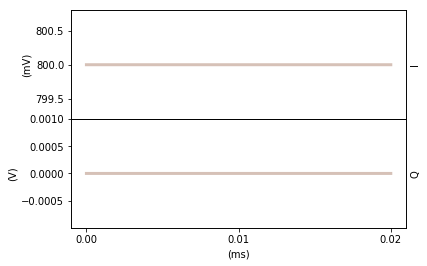

In [6]:
sidebander.change_sequence(template_element=template_element)

setting sequence_mode to element
setting element to 0
running
setting repetition_mode to inf
running


SIDEBANDER
frequency :  6000000000.0
carrier_frequency :  6000000000.0
sideband_frequency :  0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


SOURCE
frequency :  6000000000.0
power :  -10
status :  1
pulsemod_state :  0
IQ_state :  1


AWG
sample_rate :  1000000000.0
sequence_mode :  element
repetition_mode :  inf
sleep_time :  0


AWG_CH0
Vpp :  1


AWG_CH1
Vpp :  1


AWG_CH2
Vpp :  1


AWG_CH3
Vpp :  1


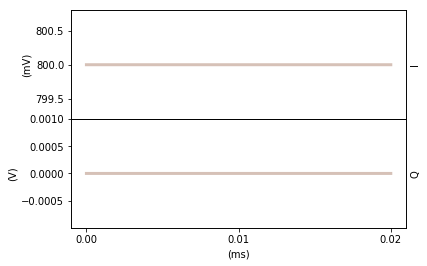

In [7]:
sidebander.to_default()
print_params(sidebander)
print_params(carrier_if)
print_params(awg_if)

So far we haven't actually done any sidebanding but now lets change the frequency parameter. This will cause an upload to the AWG to do the sidebanding to produce the correct freqeuncy.

uploading
setting element to 0
running


SIDEBANDER
frequency :  6001000000.0
carrier_frequency :  6000000000.0
sideband_frequency :  1000000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


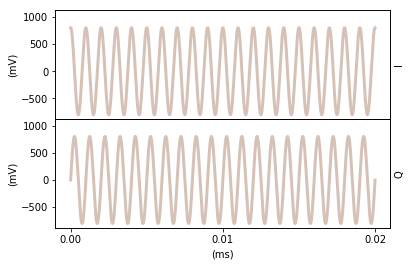

In [8]:
sidebander.frequency(6.001e9)
print_params(sidebander)

You can also change this by setting the sideband_frequency (causes a new sideband to be upladed and updates the saved frequency value) or change the carrier_frequency (updates the saved frequency value)

uploading
setting element to 0
running


SIDEBANDER
frequency :  6002000000.0
carrier_frequency :  6000000000.0
sideband_frequency :  2000000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


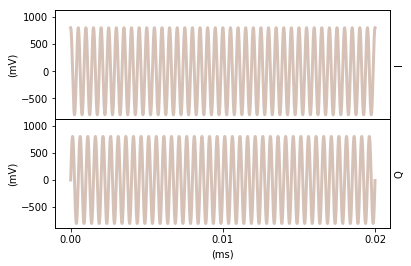

In [9]:
sidebander.sideband_frequency(2e6)
print_params(sidebander)

In [10]:
sidebander.carrier_frequency(6.9e9)
print_params(sidebander)
print_params(carrier_if)



SIDEBANDER
frequency :  6902000000.0
carrier_frequency :  6900000000.0
sideband_frequency :  2000000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


SOURCE
frequency :  6900000000.0
power :  -10
status :  1
pulsemod_state :  0
IQ_state :  1


You may have noticed that we did a new upload for every parameter change but we could also upload a sequence and then change betweeen elements of the sequence to save time. On upload it attempts to preserve the frequency (but now changing frequency doesn't necessarily require a new upload)

uploading
setting element to 0
running
setting element to 2
running


SIDEBANDER
frequency :  6902000000.0
carrier_frequency :  6900000000.0
sideband_frequency :  2000000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


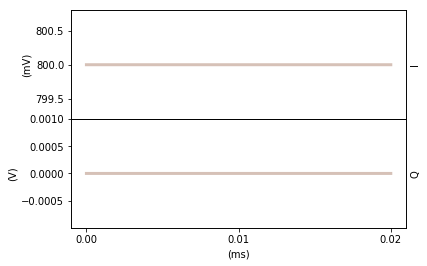

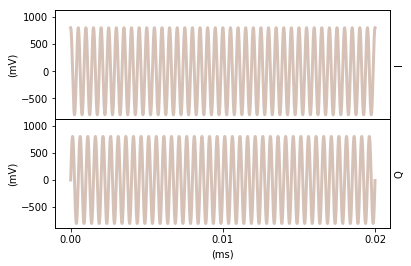

In [11]:
sidebander.change_sequence(inner_setpoints=('sideband_frequency', np.arange(10) * 1e6))
print_params(sidebander)

setting element to 5
running


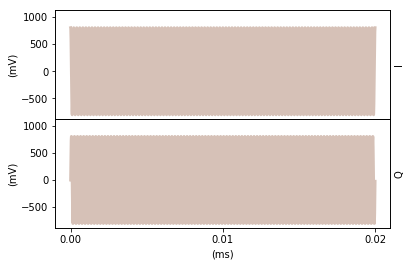

In [12]:
sidebander.sideband_frequency(5e6)

This is great to quickly traverse the setpoints uploaded but now if I try to set the parameter outside of this it won't be happy as the desired behaviour is not clear (should a new single element sequence be uploaded? should a new sequence which also includes this element be included...?). Here I try to set a frequency which would require a 88MHz sideband.

In [13]:
try:
    sidebander.frequency(6.02e9)
except Exception as e:
    print(e)

("('Error setting repeated element corressponding to the inner setpoints sideband_frequency: \\nValue -880000000.0 is outside of range (-500000.0, 9500000.0)', 'setting ps_repeat_parameters_sideband_frequency to -880000000.0'). Try changing the setpoints to include this value or set them to None", 'setting sidebander_sideband_frequency to -880000000.0', 'setting sidebander_frequency to 6020000000.0')


As suggested if you change the inner setpoints to None a single element matching the suggested parameters will be uploaded.

uploading
setting element to 0
running


SIDEBANDER
frequency :  6905000000.0
carrier_frequency :  6900000000.0
sideband_frequency :  5000000.0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


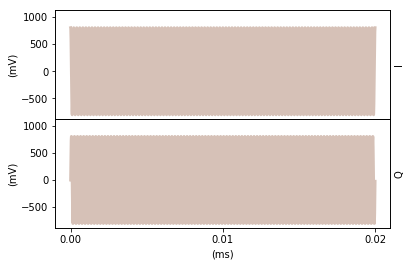

In [14]:
sidebander.change_sequence(inner_setpoints=None)
print_params(sidebander)

Having handily copied the parametric sequencers ability to change multiple parameters with only one sequence upload...

uploading
setting element to 0
running


SIDEBANDER
frequency :  6900100000.0
carrier_frequency :  6900000000.0
sideband_frequency :  100000.0
I_offset :  0.15
Q_offset :  0
gain_offset :  -0.3
phase_offset :  0.39269908169872414
amplitude :  0.8
status :  1


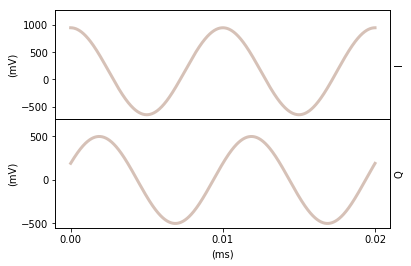

In [15]:
with sidebander.single_upload():
    sidebander.sideband_frequency(0.1e6)
    sidebander.I_offset(0.15)
    sidebander.gain_offset(-0.3)
    sidebander.phase_offset(np.pi / 8)
print_params(sidebander)